Calculate heat flux budget to estimate relative contributions of local surface heat flux and advection to total heat flux. 
Performs this calculation and makes plots for one experiment set at a time. 

Q_total = Q_surf + Q_adv

Q_total = p_sw * C_sw * h * dT/dt

Total heat flux = density of seawater * heat capacity of sw * depth of water column * change in Temp over time
    W/m^2 =            (kg/m^3) *            (J/ kgK) *              (m) *                     (K/s)
J = W s

In [11]:
from matplotlib import pyplot as plt
import numpy as np
from Datasets import wind_order_forcings, warm_order_forcings,\
exp_set_dict_wind_order, exp_set_dict_warm_order, colors_dict, all_runs_wind_order
import Functions_load_output as flo
import Functions_data_analysis as fda
import Functions_plotting as fp
from scipy.stats import linregress
import xarray as xr

In [2]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/uwas0134/Gemma/Analysis/Resubmission Figs/Functions_plotting.py'>

In [3]:
# Set up variable parameters

loc = 'inner_shelf_corner' #'PITT', 'PIG' #refer to load T and Q cell. currently searches trough_idx_dict keys


here


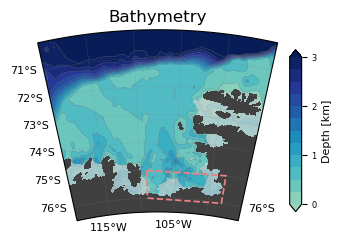

In [4]:
# Show locations of cross sections on bathymetry map
fp.plot_bathymetry_and_locs('AS_near', ['inner_shelf_corner'])
plt.savefig('Plots/Figure_bathymetry_map.png',dpi=600)

In [19]:
# set up data retrieval params
set = 'ic_2001' #'ic_1995','ic_2001','ic_2008'
colors = colors_dict[set]
runs = exp_set_dict_warm_order[set]
runs

['run_forc_erai_1982_rep_ic_2008',
 'run_forc_erai_1984_rep_ic_2008',
 'run_forc_erai_1989_rep_ic_2008',
 'run_forc_erai_1992_rep_ic_2008',
 'run_forc_erai_1994_rep_ic_2008',
 'run_forc_erai_2003_rep_ic_2008',
 'run_forc_erai_2009_rep_ic_2008',
 'run_forc_erai_1991_rep_ic_2008',
 'run_forc_erai_2015_rep_ic_2008',
 'run_forc_erai_2011_rep_ic_2008']

In [20]:
# Load surface qnet for each run (using avg over lat and lon dims),contains vals for all 5 yrs

q_surf_dict = {}
forcings = []
for run in runs:
    print(run)
    exp_q_full = flo.load_experiment_ds(run, 'all', 'state_2d_set2').oceQnet
    exp_q_full = exp_q_full.isel(time = slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[loc]
        exp_q_reg = exp_q_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[loc]
        exp_q_reg = exp_q_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_q = exp_q_reg.mean(dim='lat')
    exp_q_surf = exp_q.mean(dim='lon')
    forc = run.split('run_forc_erai_')[1][0:4]+'_x5'
    q_surf_dict[run] = exp_q_surf.values
    forcings.append(forc)

print('q_surf_dict generated!')

run_forc_erai_1982_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_2015_rep_ic_2008
run_forc_erai_2011_rep_ic_2008
q_surf_dict generated!


In [21]:
# set up functions for calculating q total in anomalies

def calc_q_total(exp_T, exp_q, h, winter_mean):
    """
    For a given run, estimate q total using rho * c * h * dT/dt
    Option to calculate based on winter means (JJA) or annual means.
    dT/dt is based on changes after one year, either annual mean changes or winter mean changes.
    
    
    Inputs
    ------
    exp_T: 1d np array with shape n_times
        contains T for a single run, averaged over lats/lons and depths for a given region
    exp_q: 1d np array with shape n_times
        contains surface q data for a single run in specified region
    h: float
        depth of water column in given location
    winter_mean: bool
        if True, uses winter averagefs (JJA) instead of annual mean

    Outputs
    -------
    q_totals: list containing estimated q total for annual mean or winter mean. contains 4 values based on dT/dt for each year between 1 and 5.
    q_surf: list containing time-averaged q surf for annual mean or winter mean. contains 4 values, starting with year 2 avg. should correspond to q_totals.
    """
    
    # Set up constants
    rho_sw = 1025  # kg/m^3 
    C_sw = 3990  # J/ kgK 
    secs_per_year = 60*60*24*365 
    
    # for each year, estimate q total using change in winter-averaged T
    T_means = [] #populate with winter mean T for each year, used for calculating dT from winter to winter
    q_totals = [] #populate with estimated q based on dT
    q_surfs = []
    for i in range(5):
        print('year',i+1)

        # calculate mean over year or winter only
        if winter_mean:
            T_i = exp_T[i*12+4:i*12+7]
        else:
            T_i = exp_T[i*12:i*12+12]
        T_i_avg = np.mean(T_i)

        # if not the first year, calculate change in T from previous year and estimate q total
        if len(T_means) > 0:

            # calculate change in T from previous year
            dT = T_i_avg - T_means[i-1]
            print('dT: {:.2f}'.format(dT))

            # calculate q total
            q_tot_est = rho_sw * C_sw * h * dT / secs_per_year

            # get q surf (either annual mean or winter mean)
            if winter_mean:
                q_surf_i = np.mean(exp_q[i*12+4:i*12+7])
            else:
                q_surf_i = np.mean(exp_q[i*12:i*12+12])
            print('q total: {:.2f}'.format(q_tot_est))
            print('q surf mean: {:.2f}'.format(q_surf_i)+'\n')
            q_totals.append(q_tot_est)
            q_surfs.append(q_surf_i)

        T_means.append(T_i_avg)
        
    return q_totals, q_surfs


def get_exp_depth_avg_T(run,loc):
    """
    Load experiment T data, averaged over lats/lons and depths for specified region. 
    Returns np array with shape (60 times) 
    """
    exp_T_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').THETA
    exp_T_full = exp_T_full.isel(time=slice(0,60))
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[loc]
    exp_T_reg = exp_T_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_T_avg_lat = exp_T_reg.mean(dim='lat')
    exp_T_avg_area = exp_T_avg_lat.mean(dim='lon')
    exp_T = exp_T_avg_area.mean(dim='depth')

    return exp_T.values


# get depth at this loc (find depth corresponding to first 0 (fill vals) in T)
def get_regional_depth(run,loc):
    """
    For a given run (should be same for all runs) and location, 
    calculate the depth of the water column. 

    Returns h as a float (positive depth).
    """
    exp_T_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').THETA
    exp_T_full = exp_T_full.isel(time=slice(0,60))
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[loc]
    exp_T_reg = exp_T_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_T_avg_lat = exp_T_reg.mean(dim='lat')
    exp_T_avg_area = exp_T_avg_lat.mean(dim='lon')
    first_zero_idx = np.where(exp_T_avg_area[0]==0)[0][0]
    h = -float(exp_T_avg_area.depth[first_zero_idx]) #1409 m for inner shelf

    return h

    

In [22]:
# calculate ensemble mean timeseries of T and q surf
ens_q = np.zeros((10,60))
ens_T = np.zeros((10,60))

for i in range(10):
    run = runs[i]
    print(run)
    exp_q = q_surf_dict[run]
    exp_T = get_exp_depth_avg_T(run,loc)
    ens_q[i] = exp_q
    ens_T[i] = exp_T

em_q = np.mean(ens_q,axis=0)
em_T = np.mean(ens_T,axis=0)

run_forc_erai_1982_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_2015_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [23]:
# Save as netCDF files for Zenodo
# ic_str = 'cool'
# ic_str_list = ['warm', 'moderate', 'cool']
# exp_set_dict = {'moderate':'ic_2001','warm':'ic_1995','cool':'ic_2008'}

# #rerun for each ic set
# exp_set = exp_set_dict[ic_str]
# times = np.load('../Saved Arrays/times_'+exp_set+'.npy')
# var_names = ['inner_shelf_depth_avged_T','inner_shelf_q_surface']
# data_arrays = [ens_T, ens_q]
# data_var_dict = {}
# for var_name, data_array in zip(var_names, data_arrays):
#     data_var_dict[var_name] = (('run','time'), data_array)
# ds = xr.Dataset(data_vars = data_var_dict,
#                 coords = {'run':runs, 'time':times},
#                 attrs = {"description":"Inner shelf depth-averaged potential temperature, "
#                          "and inner shelf surface heat flux used for the heat budget calculation for the "
#                          + ic_str + " initial condition experiment set."})
# fname = 'Submission Data/Simulated_time_series/Heat_budget_variables_'+ic_str+'_ic.nc'
# ds.to_netcdf(fname)
# print(ds)
# print('Saved as',fname)

<xarray.Dataset>
Dimensions:                    (run: 10, time: 60)
Coordinates:
  * run                        (run) <U30 'run_forc_erai_1982_rep_ic_2008' .....
  * time                       (time) datetime64[ns] 2008-02-01 ... 2013-01-01
Data variables:
    inner_shelf_depth_avged_T  (run, time) float64 -0.01022 -0.01475 ... -0.1389
    inner_shelf_q_surface      (run, time) float64 196.2 76.12 ... 140.1 231.7
Attributes:
    description:  Inner shelf depth-averaged potential temperature, and inner...
Saved as Submission Data/Simulated_time_series/Heat_budget_variables_cool_ic.nc


['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001', 'run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001', 'run_forc_erai_2015_rep_ic_2001', 'run_forc_erai_2011_rep_ic_2001']


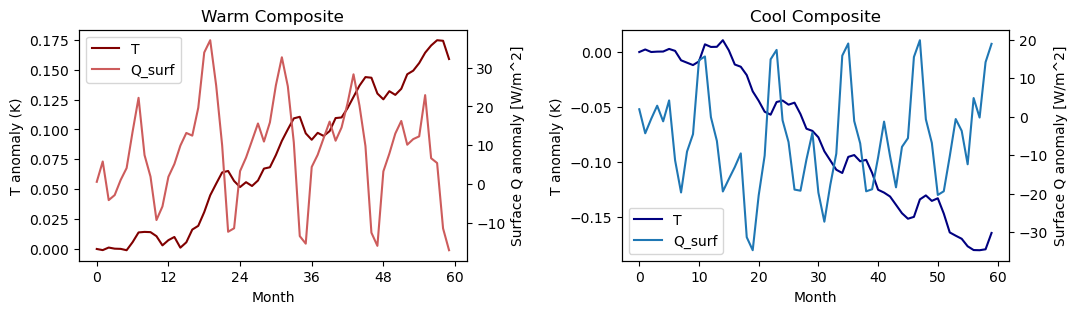

In [9]:
# calculate warm and cool composites as anomalies
print(runs)
warm_comp_q = np.mean(ens_q[0:4],axis=0)
warm_comp_T = np.mean(ens_T[0:4],axis=0)
cool_comp_q = np.mean(ens_q[4:8],axis=0)
cool_comp_T = np.mean(ens_T[4:8],axis=0)
warm_comp_q_anom = warm_comp_q - em_q
warm_comp_T_anom = warm_comp_T - em_T
cool_comp_q_anom = cool_comp_q - em_q
cool_comp_T_anom = cool_comp_T - em_T

# Plot composite anoms. This shows that warm composite Q anom is positive as T is increasing, so flux calc should be consistent. 
fig,axes = plt.subplots(1,2)
fig.set_size_inches((12,3))
ax=axes[0]
p1, = ax.plot(warm_comp_T_anom,label='T',color='maroon')
ax1 = ax.twinx()
p2, = ax1.plot(warm_comp_q_anom,label='Q_surf',color='indianred')
lines = [p1, p2]
labels = [p.get_label() for p in lines]
ax1.legend(lines, labels,loc='upper left')
ax.set_ylabel('T anomaly (K)')
ax1.set_ylabel('Surface Q anomaly [W/m^2]')
ax.set_xticks(np.arange(0,72,12))
ax.set_title('Warm Composite')
ax.set_xlabel('Month')

ax2 = axes[1]
p2, = ax2.plot(cool_comp_T_anom,label = 'T',color='navy')
ax3 = ax2.twinx()
p3, = ax3.plot(cool_comp_q_anom,label='Q_surf',color='tab:blue')
ax2.set_ylabel('T anomaly (K)')
ax3.set_ylabel('Surface Q anomaly [W/m^2]')
lines = [p2,p3]
labels = [p.get_label() for p in lines]
ax2.legend(lines,labels,loc='lower left')
plt.title('Cool Composite')
ax2.set_xlabel('Month')


plt.subplots_adjust(wspace=0.4)

Text(0.5, 1.0, 'EM Depth-avged T, surface Q at inner_shelf_corner')

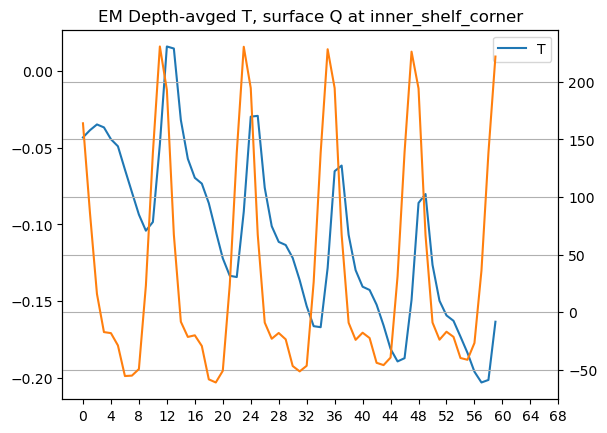

In [10]:
# Plot ensemble mean tseries
fig,ax = plt.subplots((1))
ax.plot(em_T,label='T')
plt.legend()
ax1 = ax.twinx()
ax1.plot(em_q,label='Q',color='tab:orange')
ax.set_xticks(np.arange(0,72,4))
plt.grid()
plt.title('EM Depth-avged T, surface Q at '+loc)

calculating q total using annual-mean changes in T from year to year
Calculating q total using anomaly composites...
year 1
year 2
dT: 0.03
q total: 4.80
q surf mean: 12.09

year 3
dT: 0.05
q total: 8.58
q surf mean: 10.77

year 4
dT: 0.04
q total: 7.03
q surf mean: 9.71

year 5
dT: 0.03
q total: 6.30
q surf mean: 6.76

year 1
year 2
dT: -0.02
q total: -3.61
q surf mean: -10.72

year 3
dT: -0.05
q total: -9.95
q surf mean: -8.34

year 4
dT: -0.05
q total: -9.01
q surf mean: -5.37

year 5
dT: -0.04
q total: -6.40
q surf mean: -3.01



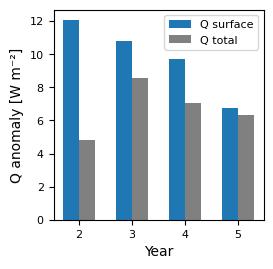

In [11]:
# calculate warm comp and cool composite q total using either anomaly timeseries or regular timeseries
anomaly = True
winter = False
if winter:
    print('Calculating q total using winter-mean changes in T for each year...')
    name = 'winter_mean'
else:
    print('calculating q total using annual-mean changes in T from year to year')
    name = 'annual_mean'

# get water column depth at this loc for a run
h = get_regional_depth(runs[0],loc)

# returns winter-averaged of annual-mean averaged means
if anomaly:
    print('Calculating q total using anomaly composites...')
    warm_q_total, warm_q_surf = calc_q_total(warm_comp_T_anom, warm_comp_q_anom, h, winter)
    cool_q_total, cool_q_surf = calc_q_total(cool_comp_T_anom, cool_comp_q_anom, h, winter)
else:
    print('Calculating q total using actual value composites...')
    warm_q_total, warm_q_surf = calc_q_total(warm_comp_T, warm_comp_q, h, winter)
    cool_q_total, cool_q_surf = calc_q_total(cool_comp_T, cool_comp_q, h, winter)


fig = plt.figure()
fig.set_size_inches((3,3))
x_vals = np.arange(2,6)
width = 0.3
# warm composite
plt.bar(x_vals-width/2,warm_q_surf,width=width,label='Q surface')
plt.bar(x_vals+width/2,warm_q_total,width=width,label='Q total',color='gray')
plt.legend(loc='upper right',fontsize=8)

plt.xticks(x_vals)
plt.ylabel('Q anomaly [W m⁻²]')
plt.xlabel('Year')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplots_adjust(top=0.9,bottom=0.2,right=0.95,left=0.25)

# plt.savefig('Plots/Figure_ED_4c_q_budget.png',dpi=400)

Text(0.5, 1.0, 'Cool composite')

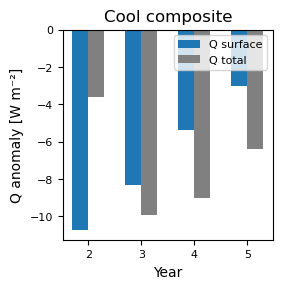

In [12]:
fig = plt.figure()
fig.set_size_inches((3,3))
x_vals = np.arange(2,6)
width = 0.3
# warm composite
plt.bar(x_vals-width/2,cool_q_surf,width=width,label='Q surface')
plt.bar(x_vals+width/2,cool_q_total,width=width,label='Q total',color='gray')
plt.legend(loc='upper right',fontsize=8)

plt.xticks(x_vals)
plt.ylabel('Q anomaly [W m⁻²]')
plt.xlabel('Year')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplots_adjust(top=0.9,bottom=0.2,right=0.95,left=0.25)
plt.title('Cool composite')